<a href="https://colab.research.google.com/github/MathBorgess/data_science_studies/blob/main/deep_learning/recurrent/speech_recognition/bird_spreech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [12]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

 99% 595M/604M [00:08<00:00, 58.6MB/s]
100% 604M/604M [00:08<00:00, 75.6MB/s]


In [15]:
import zipfile
with zipfile.ZipFile("z-by-hp-unlocked-challenge-3-signal-processing.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [ ]:
!pip install tensorflow-io

In [36]:

import tensorflow as tf
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import os

capuchin_path = os.path.join('data', 'Parsed_Capuchinbird_Clips')
not_capuchin_path = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [6]:
def load_16k_mono_audio(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample = tf.cast(sample, tf.int64)
    return tfio.audio.resample(wav, rate_in=sample, rate_out=16000)

In [17]:
load_16k_mono_audio(os.path.join(capuchin_path, os.listdir(capuchin_path)[0]))

<tf.Tensor: shape=(80000,), dtype=float32, numpy=
array([-1.9102599e-07,  5.4285999e-07, -5.1341158e-07, ...,
        4.7466299e-03,  2.0376272e-03, -1.0874035e-03], dtype=float32)>

In [31]:
contain_bird_dataset = tf.data.Dataset.list_files(capuchin_path + '/*.wav')
contain_not_bird_dataset = tf.data.Dataset.list_files(not_capuchin_path + '/*.wav')

contain_bird_dataset = tf.data.Dataset.zip((contain_bird_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(contain_bird_dataset)))))
contain_not_bird_dataset = tf.data.Dataset.zip((contain_not_bird_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(contain_not_bird_dataset)))))
dataset = contain_bird_dataset.concatenate(contain_not_bird_dataset)

In [32]:
wave_lengths = list()
for wav in os.listdir(capuchin_path):
  tensor_wave = load_16k_mono_audio(os.path.join(capuchin_path, wav))
  wave_lengths.append(len(tensor_wave))

In [25]:
[tf.math.reduce_mean(wave_lengths), tf.math.reduce_min(wave_lengths), tf.math.reduce_max(wave_lengths)]

[<tf.Tensor: shape=(), dtype=int32, numpy=54156>,
 <tf.Tensor: shape=(), dtype=int32, numpy=32000>,
 <tf.Tensor: shape=(), dtype=int32, numpy=80000>]

In [34]:
def preprocess(filename, label):
  wav = load_16k_mono_audio(filename)
  wav = wav[:50000]
  zero_padding = tf.zeros([50000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding,wav], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

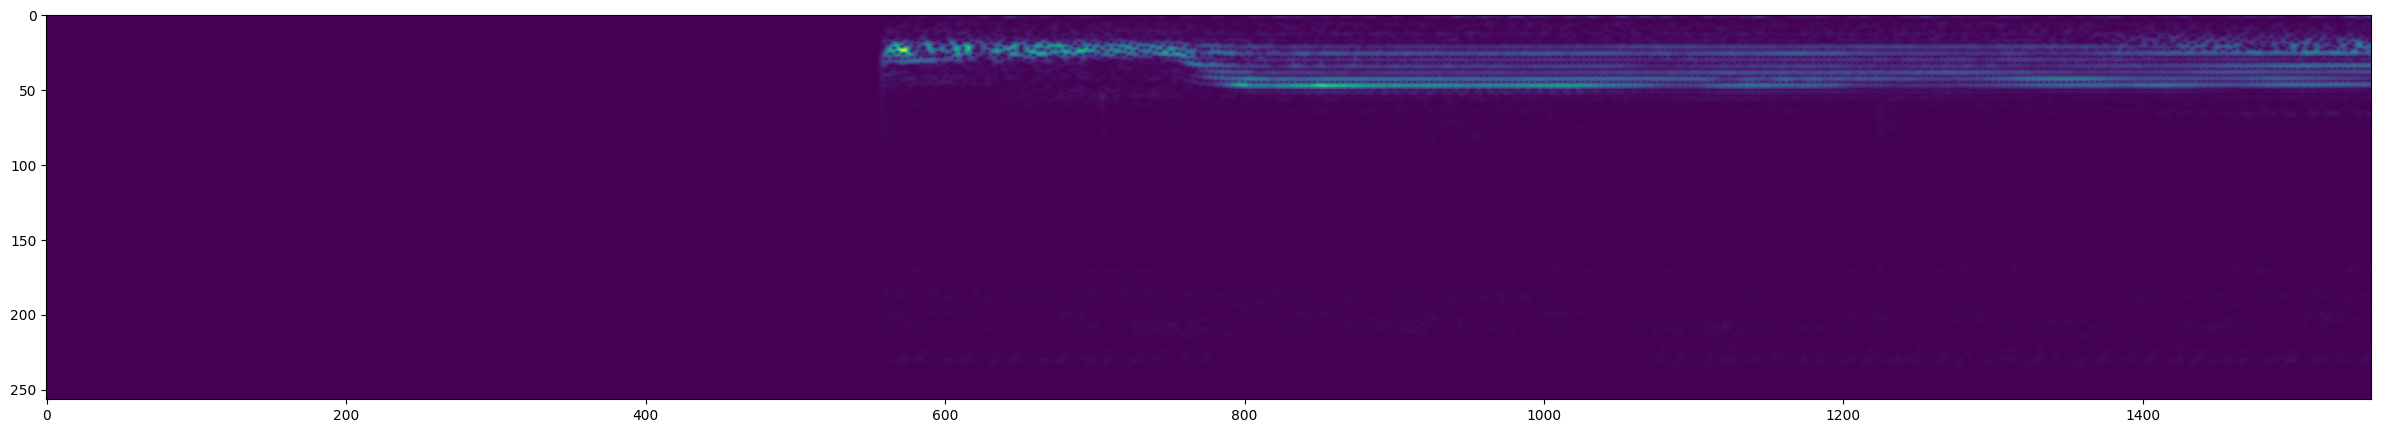

In [37]:
filepath, label = contain_bird_dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()